In [ ]:
!nvidia-smi

Fri Jun 25 07:13:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Fine-Tune BERT for sarcasm dectection with TensorFlow**

## Task 2: Setup your TensorFlow and Colab Runtime

### Install TensorFlow and TensorFlow Model Garden

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.5.0


In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 506), reused 1386 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 24.41 MiB/s, done.
Resolving deltas: 100% (506/506), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [ ]:
!pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 1.1MB 7.4MB/s 
     |████████████████████████████████| 686kB 39.7MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 358kB 27.7MB/s 
     |████████████████████████████████| 102kB 5.6MB/s 
     |████████████████████████████████| 38.2MB 1.5MB/s 
     |████████████████████████████████| 645kB 28.4MB/s 
     |████████████████████████████████| 1.2MB 28.9MB/s 
     |████████████████████████████████| 215kB 27.3MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


## Task 3: Download and Import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/sarcasm/reddit/balanced_politics_subset.csv")
df.head()

,label,comment,parent_comment
0,0,NC and NH.,"Yeah, I get that argument. At this point, I'd ..."
1,0,I think a significant amount would be against ...,I bet if that money was poured into college de...
2,0,because it's what really bothers him... and it...,He actually acts like a moody emo girl on twit...
3,0,Conservatism as an ideology is for sure a reac...,"I still doubt that ""all conservatives stand fo..."
4,0,"Maybe not control, but certainly that is evide...",Today Russian media tweeted out that Wikileaks...


In [ ]:
df=df.sample(frac=1)

In [ ]:
df.tail()

,label,comment,parent_comment
452,0,When did the majority of voters from both part...,"If he is more qualified, yes. The Electoral Co..."
2090,0,[faints],Love you too.
24243,1,"Who the hell is fueling this insanity,",Muslim Woman's Blouse Set On Fire In Possible ...
295,0,You sound pretty racist.,Trump gives Black man a second chance. Democra...
1964,0,Well I'll respect their right to rule this cou...,You shouldn't discount them as children who ca...


In [ ]:
df['pair']=df['parent_comment']+str(" ")+df['comment']

In [ ]:
df['pair'].replace('', np.nan, inplace=True)
df['pair'].replace('nan', np.nan, inplace=True)
df.dropna(subset=['pair'], inplace=True)

In [ ]:
df['pair']=df['pair'].astype(str)

In [ ]:
import re

In [ ]:
def text_preprocessing(text):

    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
df['pair']=df['pair'].apply(text_preprocessing)

## Task 4: Create tf.data.Datasets for Training and Evaluation

In [ ]:
from sklearn.model_selection import train_test_split
train_df, remaining = train_test_split(df, random_state=42, train_size=0.80, stratify=df.label.values)
valid_df, test_df = train_test_split(remaining, random_state=42, train_size=0.50, stratify=remaining.label.values)

In [ ]:
train_df.shape, valid_df.shape, test_df.shape

((24937, 4), (3117, 4), (3118, 4))

Train data for BERT

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((train_df.pair.values, train_df.label.values))
valid_data = tf.data.Dataset.from_tensor_slices((valid_df.pair.values, valid_df.label.values))
#test_data = tf.data.Dataset.from_tensor_slices((test_df.comment.values, test_df.label.values))
for text, label in train_data.take(1):
  print(text)
  print(label)

tf.Tensor(b'Guilty until proven innocent... And you guys claim to be the real Americans How can we prove her innocense if no is willing to take her to court?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## Task 5: Download a Pre-trained BERT Model from TensorFlow Hub

In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1] # Label categories
max_seq_length = 128 # maximum length of (token) input sequences
train_batch_size = 32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert.tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer.convert_tokens_to_ids(["[CLS]","[SEP]"])

[101, 102]

In [ ]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

## Task 6: Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="300px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [ ]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(),
                                            text_b = None,
                                            label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## Task 7: Wrap a Python Function into a TensorFlow op for Eager Execution

In [ ]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  # py_func doesn't set the shape of the returned tensors.
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

## Task 8: Create a TensorFlow Input Pipeline with `tf.data`

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          #.cache()
                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [ ]:
# data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
# data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Task 9: Define Model

In [ ]:
# Building the model
def create_model():
  #BERT
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])


  #last4layers  = tf.keras.layers.Concatenate()([all_layer_output[-1], all_layer_output[-2], all_layer_output[-3], all_layer_output[-4]])

  net1 = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(sequence_output)
  net1 = tf.keras.layers.MaxPooling1D(4)(net1)

  net2 = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(sequence_output)
  net2 = tf.keras.layers.MaxPooling1D(4)(net2)

  net3 = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(sequence_output)
  net3 = tf.keras.layers.MaxPooling1D(4)(net3)

  net  = tf.keras.layers.Concatenate()([net1, net2, net3])

  net = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(net)
  net = tf.keras.layers.MaxPooling1D(4)(net)

  #net = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(net)
  #net = tf.keras.layers.MaxPooling1D(4)(net)


  net = tf.keras.layers.Flatten()(net)
 # net = tf.keras.layers.Dropout(0.1)(net)
  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(net)


  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids,
    },
    outputs=output)
  return model

###Fine-Tune BERT for Text Classification

In [ ]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-6),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

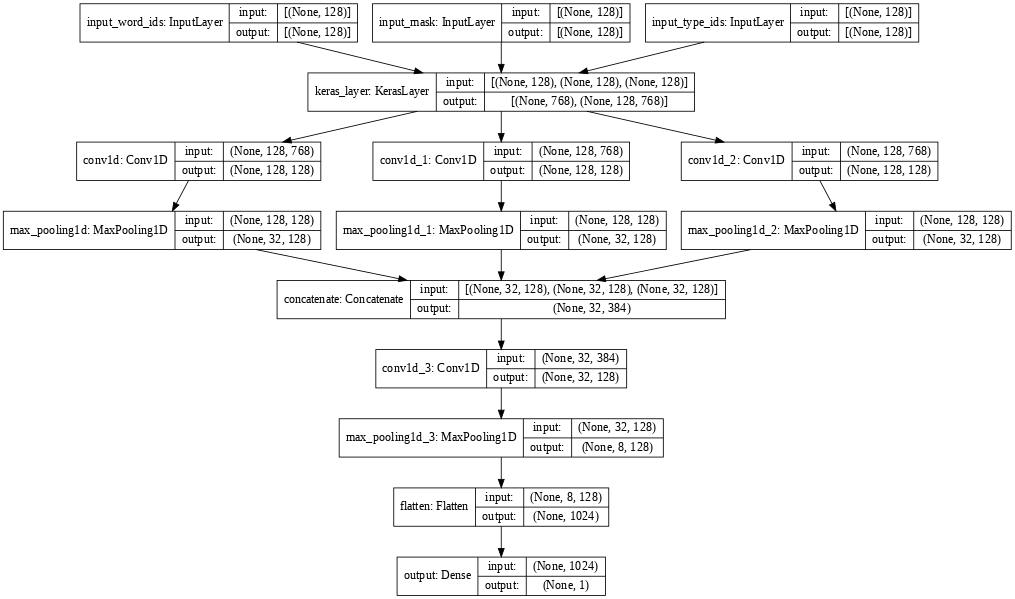

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=60, )

### Evaluate the BERT Text Classification Model

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
#es1 = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1)

es = ModelCheckpoint("my_keras_model.h5", save_best_only=True)
es1 = EarlyStopping(patience=1, restore_best_weights=True)


In [ ]:
# Train model
epochs = 5
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1,callbacks=[es, es1])

Epoch 1/5
779/779 [==============================] - 426s 507ms/step - loss: 0.6635 - binary_accuracy: 0.5930 - val_loss: 0.6037 - val_binary_accuracy: 0.6778
Epoch 2/5
779/779 [==============================] - 396s 506ms/step - loss: 0.5867 - binary_accuracy: 0.6912 - val_loss: 0.5483 - val_binary_accuracy: 0.7191
Epoch 3/5
779/779 [==============================] - 395s 505ms/step - loss: 0.5389 - binary_accuracy: 0.7298 - val_loss: 0.5252 - val_binary_accuracy: 0.7397
Epoch 4/5
779/779 [==============================] - 395s 505ms/step - loss: 0.5049 - binary_accuracy: 0.7553 - val_loss: 0.5137 - val_binary_accuracy: 0.7487
Epoch 5/5
779/779 [==============================] - 395s 505ms/step - loss: 0.4772 - binary_accuracy: 0.7712 - val_loss: 0.5153 - val_binary_accuracy: 0.7490


### Plots

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

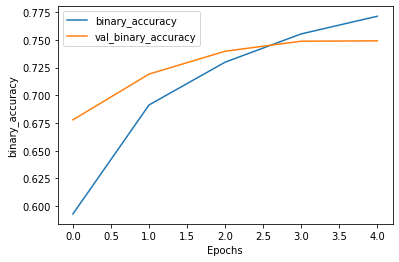

In [ ]:
plot_graphs(history, 'binary_accuracy')

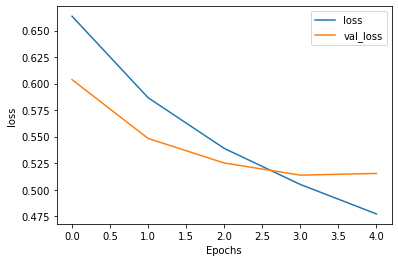

In [ ]:
plot_graphs(history, 'loss')

In [ ]:
eval=model.evaluate(valid_data, verbose=1)

97/97 [==============================] - 16s 164ms/step - loss: 0.5137 - binary_accuracy: 0.7487


## Testing

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((test_df.pair.values, [0]*test_df.shape[0]))
test_data = (test_data.map(to_feature_map).batch(1))

In [ ]:
eval=model.evaluate(test_data, verbose=1)

3118/3118 [==============================] - 43s 13ms/step - loss: 1.0509 - binary_accuracy: 0.5318


In [ ]:
eval

[1.05087149143219, 0.5317510962486267]

In [ ]:
true_label=test_df['label']

In [ ]:
true_label.shape

(3118,)

In [ ]:
test_df.label.sum()

1559

In [ ]:
pred_label = model.predict(test_data)

In [ ]:
pred_label.shape

(3118, 1)

In [ ]:
type(pred_label)

numpy.ndarray

In [ ]:
pred=[1 if pred >=0.46 else 0 for pred in pred_label]

In [ ]:
sum(pred)

1531

In [ ]:
from pandas import DataFrame
pred_df = DataFrame (pred,columns=['pred_label'])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
precision_score(true_label,pred_df),recall_score(true_label,pred_df),f1_score(true_label,pred_df),accuracy_score(true_label,pred_df)

(0.7483912483912484,
 0.7459910198845414,
 0.7471892065531641,
 0.7475946119307249)

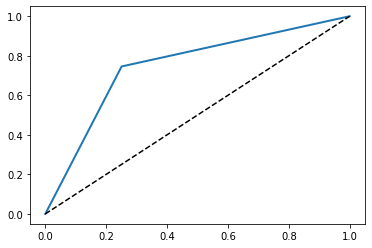

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(true_label, pred_df)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(true_label, pred_df)

0.7475946119307249

## Model-2

In [ ]:
# Building the model
def create_model():
  #BERT
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  net1 = tf.keras.layers.Conv1D(filters=50, kernel_size=4, padding='valid', activation='relu')(sequence_output)
  net1 = tf.keras.layers.MaxPooling1D()(net1)

  net2 = tf.keras.layers.Conv1D(filters=50, kernel_size=4, padding='valid', activation='relu')(sequence_output)
  net2 = tf.keras.layers.MaxPooling1D()(net2)

  net3 = tf.keras.layers.Conv1D(filters=50, kernel_size=4, padding='valid', activation='relu')(sequence_output)
  net3 = tf.keras.layers.MaxPooling1D()(net3)

  net  = tf.keras.layers.Concatenate()([net1, net2, net3])

  net = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu')(net)
  net = tf.keras.layers.MaxPooling1D()(net)
  net = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='valid', activation='relu')(net)
  net = tf.keras.layers.MaxPooling1D()(net)

  #net = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')(net)
  #net = tf.keras.layers.MaxPooling1D(4)(net)


  net = tf.keras.layers.Flatten()(net)
 # net = tf.keras.layers.Dropout(0.1)(net)
  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(net)


  model1 = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids,
    },
    outputs=output)
  return model1

In [ ]:
model1 = create_model()
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-6),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
#es1 = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1)

es = ModelCheckpoint("my_keras_model.h5", save_best_only=True)
es1 = EarlyStopping(patience=1, restore_best_weights=True)


In [ ]:
# Train model
epochs = 5
history = model1.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1,callbacks=[es, es1])

Epoch 1/5
779/779 [==============================] - 399s 502ms/step - loss: 0.5483 - binary_accuracy: 0.7241 - val_loss: 0.5197 - val_binary_accuracy: 0.7497
Epoch 2/5
779/779 [==============================] - 392s 501ms/step - loss: 0.4856 - binary_accuracy: 0.7692 - val_loss: 0.5131 - val_binary_accuracy: 0.7587
Epoch 3/5
779/779 [==============================] - 392s 501ms/step - loss: 0.4548 - binary_accuracy: 0.7896 - val_loss: 0.5088 - val_binary_accuracy: 0.7658
Epoch 4/5
779/779 [==============================] - 392s 501ms/step - loss: 0.4276 - binary_accuracy: 0.8045 - val_loss: 0.5329 - val_binary_accuracy: 0.7487


### Testing

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((test_df.pair.values, [0]*test_df.shape[0]))
test_data = (test_data.map(to_feature_map).batch(1))

In [ ]:
eval=model1.evaluate(test_data, verbose=1)

3118/3118 [==============================] - 42s 13ms/step - loss: 1.1838 - binary_accuracy: 0.4981


In [ ]:
eval

[1.1838105916976929, 0.4980756938457489]

In [ ]:
true_label=test_df['label']

In [ ]:
true_label.shape

(3118,)

In [ ]:
test_df.label.sum()

1559

In [ ]:
pred_label = model1.predict(test_data)

In [ ]:
pred_label.shape

(3118, 1)

In [ ]:
type(pred_label)

numpy.ndarray

In [ ]:
pred=[1 if pred >=0.46 else 0 for pred in pred_label]

In [ ]:
sum(pred)

1645

In [ ]:
from pandas import DataFrame
pred_df = DataFrame (pred,columns=['pred_label'])

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
precision_score(true_label,pred_df),recall_score(true_label,pred_df),f1_score(true_label,pred_df),accuracy_score(true_label,pred_df)

(0.7227963525835867,
 0.7626683771648493,
 0.7421972534332085,
 0.7350865939704939)

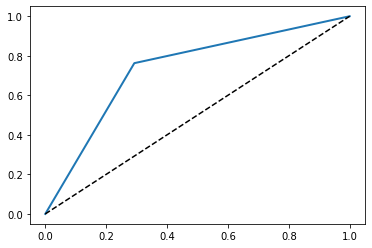

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(true_label, pred_df)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')

plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(true_label, pred_df)

0.7350865939704939